# Spatial dataframes from CSV files
If a CSV file includes coordinates - either a coordinate pair representing a point location, or a series of coordinate pairs depicting a line or a polygon's permiter - then we can use those coordinates to construct a geometric object and thus create a spatially enabled dataframe, which in Geopandas is referred to as a <u>geodataframe</u>. 

Here we focus on the steps involved in going from raw coordinate data stored in a field of CSV file to a spatial dataframe. We first look at the techniques using <u>Geopandas</u> and then those using the <u>ArcGIS Python API</u>. 
<font color='brown'>(*Note that Geopandas refers to spatial dataframes and "geodataframes" and the ArcGIS Python API sometimes refers to them as "spatially enabled dataframes"; I will use those terms interchangeably...*)</font>

In exploring the **Geopandas** technique, we discuss the hierarchy of components that go into adding spatial elements to a dataframe: from geometries, to geoseries, and finally to geodataframes and see where the Shapely package (installed as one of Geopandas' dependencies) is used in the process. 

Then, we see that the same process of converting a CSV file to a spatial dataframe using the **ArcGIS Python API** is a bit easier at first, but that the spatial dataframe produced is a bit more difficult to manipulate. 

We'll examine this process with a simple example of creating a point spatial dataframe from a CSV file containing latitude and longitude coordinates. The data we'll use in this exercise is electric vehicle charging locations in North Carolina ([source](https://afdc.energy.gov/data_download)).

## 1. Constructing a Pandas dataframe from the CSV file
The first step in creating the geodataframe from the CSV file - for both the *Geopandas* and *ArcGIS API* methods - is to read it in as a simple Pandas dataframe. 

In [1]:
#Import pandas 
import pandas as pd

In [2]:
#Read the EV Charging station data into a Pandas dataframe
df_EVStations = pd.read_csv(r"V:\Part5_DataScience\SpatialDataFrames\data\NC_Charging_Stations.csv")

In [3]:
#Examine the columns, noting the data include "latitude"  "longitude" columns
df_EVStations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 738 entries, 0 to 737
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   index                             738 non-null    int64  
 1   Fuel Type Code                    738 non-null    object 
 2   Station Name                      738 non-null    object 
 3   City                              738 non-null    object 
 4   State                             738 non-null    object 
 5   ZIP                               738 non-null    int64  
 6   Status Code                       738 non-null    object 
 7   Groups With Access Code           738 non-null    object 
 8   Latitude                          738 non-null    float64
 9   Longitude                         738 non-null    float64
 10  ID                                738 non-null    int64  
 11  Updated At                        738 non-null    object 
 12  Country 

---
## GeoPandas
* http://geopandas.org/data_structures.html
* http://geopandas.org/io.html

### 2. Creating geometries from latitude and longitude coordinates
Now that we have our dataframe with its coordinate values, the next step is to convert these raw coordinate values into geometric objects, points in our case. This is done with the `shapely` package. First, we'll demonstrate how this is done with a single coordinate pair, and then reveal a nifty way to do this for all coordinate pairs in our dataframe.

#### Creating a single point geometry from a single coordinate pair

In [19]:
#Extract latitude and longitude values from our first record
theLat = df_EVStations.loc[0,'Latitude']
theLng = df_EVStations.loc[0,'Longitude']
print (theLat,theLng)

35.2269135 -80.8501816


In [5]:
#Import the Point class from shapely's geometry module
from shapely.geometry import Point

In [6]:
#Construct a shapely point from our XY coordinates
thePoint = Point(theLng,theLat)
type(thePoint)

shapely.geometry.point.Point

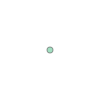

In [7]:
#Display the point
thePoint

Ok, we now have a point object. What we next need to do is repeat this process for all records in our dataframe, storing the geometries in a new list. 

We could simply iterate through all rows in our dataframe (e.g. using Pandas' `iterrow()` function. However, a much more elegant and efficient method exists using Python's "list comprehension" methods. (See more [here](https://www.pythonforbeginners.com/basics/list-comprehensions-in-python) on list comprehension...)

#### Creating a list of point geometries by iterating through all records

In [34]:
#Old style:
thePoints = []
for i,row in df_EVStations.iterrows():
    theLat = row['Latitude']
    theLng = row['Longitude']
    thePoint = Point(theLng,theLat)
    thePoints.append(thePoint)

print(type(i))
print(type(row))

<class 'int'>
<class 'pandas.core.series.Series'>


#### Creating a list of point geometries by iterating through all records - *using list comprehension*

In [28]:
#New style: Using list comprehension
thePointsZip = [Point(xy) for xy in zip(df_EVStations['Longitude'],df_EVStations['Latitude'])]
len(thePointsZip)

738

In [29]:
type(thePointsZip)


list

---
#### → Understanding *list comprehension*
*A lot is going on in the above statement. Let's pause and break it down...*

* First, the `zip(df_EVStations['Longitude'],df_EVStations['Latitude'])` code creats a Python "zip" object which is a combination two (or more) collections of the same length that now share a common index. Take a look:

In [30]:
#Zip the two columns of data such that they share a common index
zipObject = zip(df_EVStations['Longitude'],df_EVStations['Latitude'])
#Convert the zip object to a list
zipAsList = list(zipObject)
#Reveal the first 3 object in the list
zipAsList[:3]

[(-80.8501816, 35.2269135), (-78.64347, 35.778416), (-78.642287, 35.77435)]

* The second action in the statement is a `for` loop that iterates through each item in the new `zip` object, assigning the current value in each iteration (i.e. coordinate pair) to the variable named `xy`.
* And the third action is constucting a Point object using this coordinate pair, again done within the for loop. 
* Finally, if you note that the entire statement is enclosed in brackets just like any Python list. This is meaningful because the result of each iteration is stored as a list which we assign to the variable `thePoints`.

*List comprehension is a clever scripting technique. Some argue that it's less "Pythonic", but I've seen it more and more in Python scripts...*

---

### 3. Creating the geodataframe
We are almost there! 

The remaining step in the Geopandas method is to convert our existing Pandas dataframe to a GeoPandas *geo*dataframe. To do this we simply call the GeoPandas `GeoDataFrame` command, referencing the original dataframe, the list of geometries corresponding to each row in this dataframe, and the <u>coordinate reference system</u> or **crs** to which our geometries are referenced. 

These coordinate reference systems can actually take many forms. But most often, you'll just use the format shown below, replacing the `4326` with the "WKID" of any coordinate reference system listed at https://spatialreference.org.  

In [24]:
#Import geopandas
import geopandas

In [25]:
#Create a coordinate reference system dictionary for WGS84 (WKID=4326)
theCRS = 4326

In [32]:
df_EVStations.size

11070

In [33]:
len(thePoints)

1

In [35]:
#Create the spatial dataframe from the Pandas dataframe, the geometry collection and crs
gdf_EVStations = geopandas.GeoDataFrame(
    df_EVStations,      #Source of the data
    geometry=thePoints, #Field containing geometries
    crs=theCRS)         #Coordinate reference system of the geometries

#Display the type of the object created
type(gdf_EVStations)

geopandas.geodataframe.GeoDataFrame

* Explore the geodataframe...

In [29]:
#Show info for the dataframe; note the new column at the end
gdf_EVStations.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 738 entries, 0 to 737
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   index                             738 non-null    int64   
 1   Fuel Type Code                    738 non-null    object  
 2   Station Name                      738 non-null    object  
 3   City                              738 non-null    object  
 4   State                             738 non-null    object  
 5   ZIP                               738 non-null    int64   
 6   Status Code                       738 non-null    object  
 7   Groups With Access Code           738 non-null    object  
 8   Latitude                          738 non-null    float64 
 9   Longitude                         738 non-null    float64 
 10  ID                                738 non-null    int64   
 11  Updated At                        738 non-null    

In [30]:
#Examine the data; note the last column contains Shapely point geometries
gdf_EVStations.head()

,index,Fuel Type Code,Station Name,City,State,ZIP,Status Code,Groups With Access Code,Latitude,Longitude,ID,Updated At,Country,Groups With Access Code (French),Access Code,geometry
0,312,ELEC,DUKE ENERGY,Charlotte,NC,28202,E,Public,35.226914,-80.850182,38892,2019-11-14 10:14:28 UTC,US,Public,public,POINT (-80.85018 35.22691)
1,332,ELEC,City of Raleigh - Municipal Building,Raleigh,NC,27601,E,Public,35.778416,-78.643470,39016,2019-11-08 19:38:10 UTC,US,Public,public,POINT (-78.64347 35.77842)
2,333,ELEC,City of Raleigh - Downtown,Raleigh,NC,27601,E,Public,35.774350,-78.642287,39017,2019-11-08 19:38:10 UTC,US,Public,public,POINT (-78.64229 35.77435)
3,621,ELEC,Modern Nissan - Concord,Concord,NC,28027,E,Public - Call ahead,35.392063,-80.622777,40066,2019-09-09 14:29:53 UTC,US,Public - Appeler à l'avance,public,POINT (-80.62278 35.39206)
4,622,ELEC,Fred Anderson Nissan,Fayetteville,NC,28304,E,Public - Call ahead,35.042419,-78.956747,40067,2019-09-09 14:29:53 UTC,US,Public - Appeler à l'avance,public,POINT (-78.95675 35.04242)


* Visualize the data... (more info [here](https://geopandas.org/mapping.html))

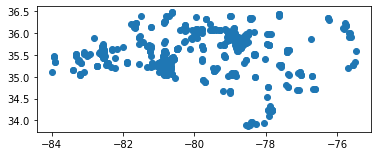

In [36]:
#Create a simple plot
gdf_EVStations.plot();

In [37]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

In [ ]:
#Preview of some plot visualization options...
gdf_EVStations.plot(marker='.',        #Default marker to use for points. (Try)
                    color='red',
                    alpha=0.2,
                    markersize=100,
                    figsize=(18,5));

## Geopandas -- all in one place
So, let's look at all those steps in one short script - good for reference.

In [ ]:
#Import packages
import pandas as pd
import geopandas
from shapely.geometry import Point

#Read the CSV file into a Pandas dataframe
df = pd.read_csv('./data/NC_Charging_Stations.csv')

#Create a list of point geometries from the appropriate columns
geomList = [Point(xy) for xy in zip(df['Longitude'],df['Latitude'])]

#Specify coordinate reference system of our data in the form of a dictionary
crs_NAD83 = {'init':'epsg:4326'}

#Upgrade the dataframe to spatial dataframe, assigining it to the NAD83 crs
gdf = geopandas.GeoDataFrame(df,geometry=geomList,crs=crs_NAD83)

---
---
## ArcGIS Python API
* https://developers.arcgis.com/python/guide/introduction-to-the-spatially-enabled-dataframe/#Accessing-GIS-data
* https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.features.toc.html#arcgis.features.GeoAccessor.from_xy

### 1. Create the Pandas dataframe from the CSV data
As above, saved as `df_EVStations`
### 2. Create a "Spatially Enabled Dataframe" from the Pandas dataframe
The ArcGIS Python API offers a simpler method for converting CSV coordinate data to a spatial dataframe, one that combines the two steps above. This involves the `from_xy()` method of the API's `GeoAccessor` object ([link](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.features.toc.html#arcgis.features.GeoAccessor.from_xy)).

In [ ]:
#Import the GeoAccessor module from the arcgis API
from arcgis import GeoAccessor

In [ ]:
#Re-read the EV Charging station data into a Pandas dataframe
df_EVStations = pd.read_csv('./data/NC_Charging_Stations.csv')

In [ ]:
#Convert to spatially enabled dataframe using the "from_xy() method"
sdf_EVStations = GeoAccessor.from_xy(df_EVStations,'Longitude','Latitude',sr={'wkid':4326})
type(sdf_EVStations)

What's interesting is that the above operation returns what still looks like a *Pandas* dataframe. However, this dataframe is now associated with the ArcGIS *GeoAccessor* object, which is accessed by appending `.spatial` to the dataframe (which is not a part of standard Pandas dataframes):

In [ ]:
#Reveal the new geoaccessor object linked to the dataframe
type(sdf_EVStations.spatial)

Thus, by appending `.spatial` to our *spatially enabled* dataframe, we attach a number of new actions we can do with this object. This [link](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.features.toc.html#geoaccessor) lists these actions, and below we show a few. 

In [ ]:
#Show the full extent of the sdf
sdf_EVStations.spatial.full_extent

In [ ]:
#Show the full extent as a bounding box
sdf_EVStations.spatial.bbox

In [ ]:
#Show its spatial reference
sdf_EVStations.spatial.sr

In [ ]:
#Reproject to UTM Zone 17N (wkid = 26917)
sdf_EVStations_utm = sdf_EVStations.copy(deep=True) #We first need to copy to a new SDF
sdf_EVStations_utm.spatial.project({'wkid': 26917})
sdf_EVStations_utm.spatial.sr

In [ ]:
#Plot the points
sdf_EVStations.spatial.plot()

https://developers.arcgis.com/python/guide/visualizing-data-with-the-spatially-enabled-dataframe/

In [ ]:
#Plot the points, with some embellishment
sdf_EVStations.spatial.plot(
    renderer_type='u', #Set to show each unqiue value
    col='ZIP',         #Set the field with unique values,
    marker_size=5,
    line_width=.5,
)

## ArcGIS Spatial DataFrame ↔ GeoPandas Geodataframe
We can switch back and forth between the two formats as follows:

In [ ]:
#To work with geometries we need to import the GeoSeriesAccessor class
from arcgis import GeoSeriesAccessor

In [ ]:
#Now we create that from the spatially enabled dataframe
gs_EVStations = GeoSeriesAccessor(sdf_EVStations['SHAPE'])
type(gs_EVStations)

In [ ]:
#Convert the GeoSeriesAccessor to a set of Shapely geometries
geom_EVStations = gs_EVStations.as_shapely
geom_EVStations[:5]

In [ ]:
gdf_EVStations = geopandas.GeoDataFrame(
    sdf_EVStations,      
    geometry=geom_EVStations, 
    crs=theCRS)  
type(gdf_EVStations)

In [ ]:
#Plot the geodataframe
gdf_EVStations.plot();

In [ ]:
#From GeoPandas to ArcGIS
theSDF = GeoAccessor(gdf_EVStations)
type(theSDF)

In [ ]:
#Plot
theSDF.plot()

## Recap 
Both GeoPandas and the ArcGIS Python API give us the ability to import CSV data containing coordinates into Spatial DataFrames. We've seen the simplest example in action, i.e., bringing in point features. Polyline and polygon features are a bit more tricky but can be done fairly easily using GeoPandas if the CSV includes a column listing the point coordinates that make up the vertices of the polyline or polygon.

A cool example: https://medium.com/geoai/house-hunting-the-data-scientist-way-b32d93f5a42f